In [25]:
# Cell 1
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron

np.random.seed(42)

def g_lin(n=500):
    c1 = np.random.randn(n, 2) + np.array([0, 0])
    c2 = np.random.randn(n, 2) + np.array([4, 4])
    c3 = np.random.randn(n, 2) + np.array([-4, 4])
    X = np.vstack([c1, c2, c3])
    y = np.array([0]*n + [1]*n + [2]*n)
    return X, y

def g_non(n=500):
    t = np.linspace(0, 4*np.pi, n)
    r1, r2, r3 = t, t+2, t+4
    x1 = np.c_[r1*np.cos(t), r1*np.sin(t)]
    x2 = np.c_[r2*np.cos(t), r2*np.sin(t)]
    x3 = np.c_[r3*np.cos(t), r3*np.sin(t)]
    X = np.vstack([x1, x2, x3])
    y = np.array([0]*n + [1]*n + [2]*n)
    return X, y

def prep(X, y):
    y_h = np.zeros((y.size, y.max()+1))
    y_h[np.arange(y.size), y] = 1
    X_tr, X_t, y_tr, y_t = train_test_split(X, y_h, test_size=0.4, stratify=y)
    X_v, X_te, y_v, y_te = train_test_split(X_t, y_t, test_size=0.5, stratify=np.argmax(y_t,1))
    return X_tr, X_v, X_te, y_tr, y_v, y_te

Xd1, yd1 = g_lin()
Xd2, yd2 = g_non()
D1 = prep(Xd1, yd1)
D2 = prep(Xd2, yd2)

In [26]:
# Cell 2
class NN:
    def __init__(self, l_sz):
        self.W = [np.random.randn(l_sz[i], l_sz[i+1]) for i in range(len(l_sz)-1)]
        self.b = [np.zeros((1, l_sz[i+1])) for i in range(len(l_sz)-1)]
        self.A, self.Z = [], []
    
    def sig(self, z): return 1 / (1 + np.exp(-z))
    def dsig(self, a): return a * (1 - a)
    
    def fwd(self, x):
        self.A, self.Z = [x], []
        for w, b in zip(self.W, self.b):
            z = np.dot(self.A[-1], w) + b
            self.Z.append(z)
            self.A.append(self.sig(z))
        return self.A[-1]
    
    def tr(self, X, y, ep=50, lr=0.1):
        errs = []
        for _ in range(ep):
            e = 0
            for i in range(len(X)):
                xi, yi = X[i:i+1], y[i:i+1]
                # Fwd
                o = self.fwd(xi)
                e += np.sum((yi - o)**2)
                # Bwd
                d = (o - yi) * self.dsig(o)
                for j in range(len(self.W)-1, -1, -1):
                    self.W[j] -= lr * np.dot(self.A[j].T, d)
                    self.b[j] -= lr * np.sum(d, axis=0, keepdims=True)
                    if j > 0: d = np.dot(d, self.W[j].T) * self.dsig(self.A[j])
            errs.append(e / len(X))
        return errs

def ev(m, X, y):
    p = np.argmax(m.fwd(X), axis=1)
    t = np.argmax(y, axis=1)
    return accuracy_score(t, p), confusion_matrix(t, p)

In [29]:
# Cell 3 (Corrected)
def run_exp(D, ls, ep=100):
    r = {}
    best = {'a': 0, 'm': None, 'h': None, 'l': None}
    for h in ls:
        if isinstance(h, int): s = [2, h, 3]
        else: s = [2] + list(h) + [3]
        m = NN(s)
        # Train on D[0]=X_tr, D[3]=y_tr
        l = m.tr(D[0], D[3], ep)
        # Val on D[1]=X_v, D[4]=y_v
        va, vm = ev(m, D[1], D[4])
        r[str(h)] = (va, vm)
        if va >= best['a']: best.update({'a': va, 'm': m, 'h': h, 'l': l})
        print(f"H={h}, ValAcc={va:.4f}")
    return r, best

def plt_res(b, D, t):
    # Error Plot
    plt.plot(b['l'])
    plt.title(f"{t}: Error vs Epoch (Best H={b['h']})")
    plt.show()
    
    # Boundary Plot (Train Data)
    m = b['m']
    x_min, x_max = D[0][:, 0].min()-1, D[0][:, 0].max()+1
    y_min, y_max = D[0][:, 1].min()-1, D[0][:, 1].max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    Z = np.argmax(m.fwd(np.c_[xx.ravel(), yy.ravel()]), axis=1).reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.4)
    # Corrected indexing: X=D[0], y=D[3]
    plt.scatter(D[0][:,0], D[0][:,1], c=np.argmax(D[3],1), s=20, edgecolors='k')
    plt.title(f"{t}: Decision Boundary")
    plt.show()

    # 3D Plot Loop (Train, Val, Test)
    fig = plt.figure(figsize=(15, 5))
    for i, s in enumerate(['Train', 'Val', 'Test']):
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        # Corrected indexing: X is at i, y is at i+3
        Xi, yi = D[i], D[i+3] 
        
        o = m.fwd(Xi) 
        # Plot 1st output node against input features
        ax.scatter(Xi[:,0], Xi[:,1], o[:,0], c=np.argmax(yi, 1))
        ax.set_title(f"{s} Output Node 0")
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Act')
    plt.tight_layout()
    plt.show()
    
    # Test Stats (D[2]=X_te, D[5]=y_te)
    ta, tm = ev(m, D[2], D[5])
    print(f"Best H={b['h']}\nTest Acc: {ta:.4f}\nTest CM:\n{tm}")
    
    # Perceptron Comparison
    sp = Perceptron()
    sp.fit(D[0], np.argmax(D[3],1))
    sa = sp.score(D[2], np.argmax(D[5],1))
    print(f"Single Neuron Acc: {sa:.4f}")

--- Dataset 1: Linear ---
H=2, ValAcc=0.9933
H=4, ValAcc=0.9933
H=8, ValAcc=0.9933


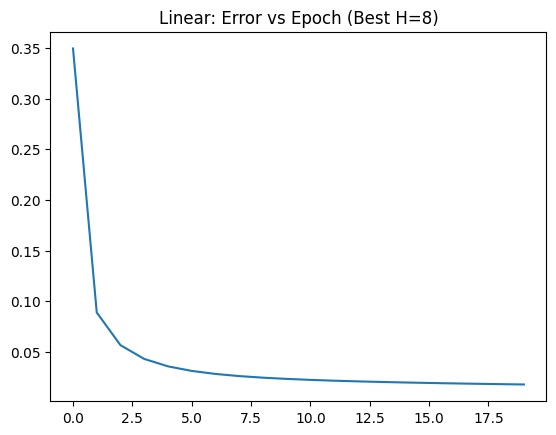

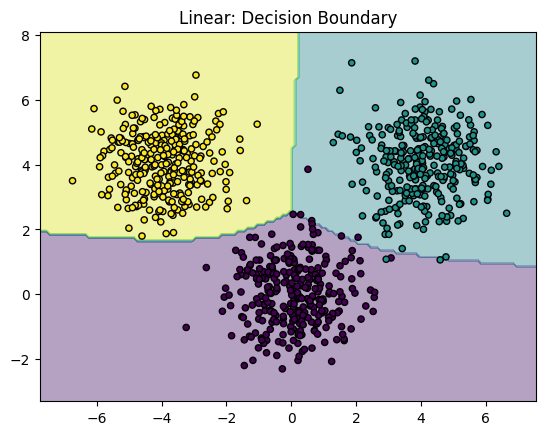

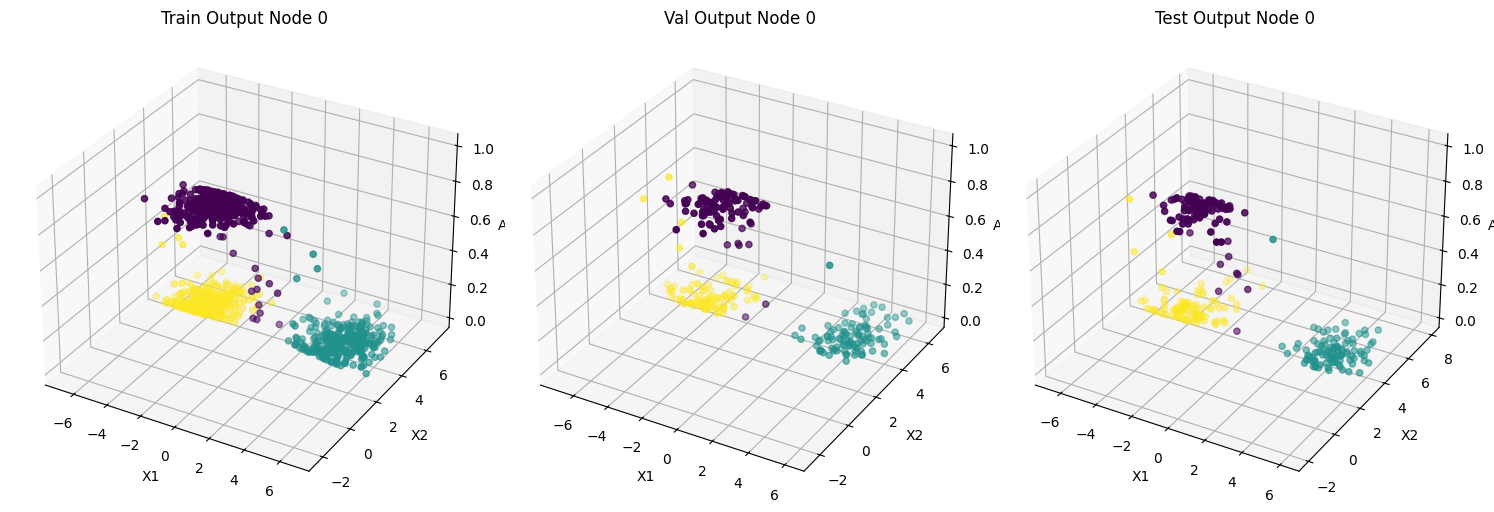

Best H=8
Test Acc: 0.9900
Test CM:
[[99  0  1]
 [ 1 99  0]
 [ 1  0 99]]
Single Neuron Acc: 0.9800

Validation Stats:
H=2: Acc=0.9933
CM:
[[ 99   0   1]
 [  0 100   0]
 [  1   0  99]]
H=4: Acc=0.9933
CM:
[[ 99   0   1]
 [  0 100   0]
 [  1   0  99]]
H=8: Acc=0.9933
CM:
[[ 99   0   1]
 [  0 100   0]
 [  1   0  99]]

--- Inferences D1 ---
1. 1 Hidden layer sufficient for linear sep.
2. FCNN matches single neuron performance.
3. Convergence is fast and smooth.


In [30]:
# Cell 4
print("--- Dataset 1: Linear ---")
R1, B1 = run_exp(D1, [2, 4, 8], ep=20)
plt_res(B1, D1, "Linear")
print("\nValidation Stats:")
for k, v in R1.items(): print(f"H={k}: Acc={v[0]:.4f}\nCM:\n{v[1]}")

print("\n--- Inferences D1 ---")
print("1. 1 Hidden layer sufficient for linear sep.")
print("2. FCNN matches single neuron performance.")
print("3. Convergence is fast and smooth.")

--- Dataset 2: Non-Linear ---
H=(4, 4), ValAcc=0.5067
H=(8, 8), ValAcc=0.5267
H=(16, 16), ValAcc=0.4733


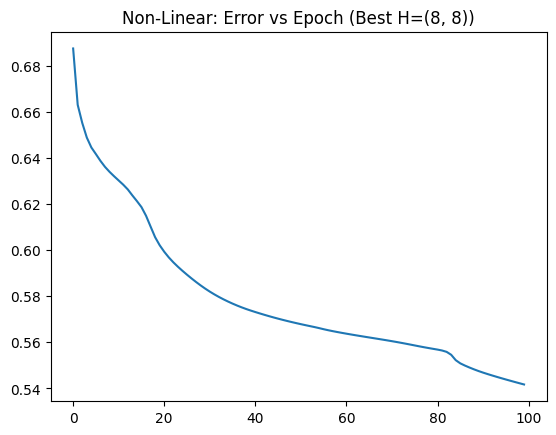

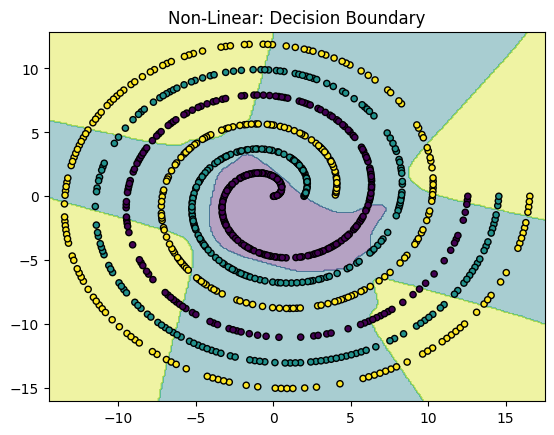

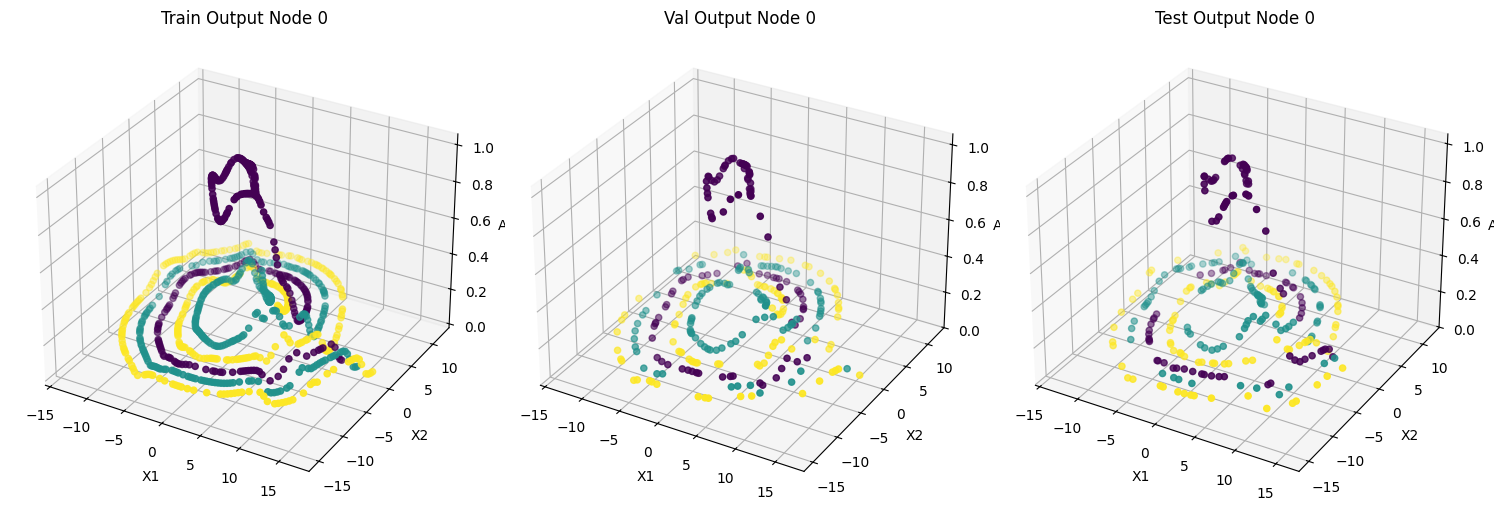

Best H=(8, 8)
Test Acc: 0.5200
Test CM:
[[47 32 21]
 [ 0 81 19]
 [ 0 72 28]]
Single Neuron Acc: 0.3633

Validation Stats:
H=(4, 4): Acc=0.5067
CM:
[[47 38 15]
 [ 3 78 19]
 [ 2 71 27]]
H=(8, 8): Acc=0.5267
CM:
[[48 38 14]
 [ 0 80 20]
 [ 0 70 30]]
H=(16, 16): Acc=0.4733
CM:
[[48 29 23]
 [ 8 59 33]
 [ 0 65 35]]

--- Inferences D2 ---
1. Single neuron fails (Acc ~33-50%).
2. 2 Hidden layers capture spiral/circular bounds.
3. Higher node count improves boundary smoothness.


In [31]:
# Cell 5
print("--- Dataset 2: Non-Linear ---")
R2, B2 = run_exp(D2, [(4,4), (8,8), (16,16)], ep=100)
plt_res(B2, D2, "Non-Linear")
print("\nValidation Stats:")
for k, v in R2.items(): print(f"H={k}: Acc={v[0]:.4f}\nCM:\n{v[1]}")

print("\n--- Inferences D2 ---")
print("1. Single neuron fails (Acc ~33-50%).")
print("2. 2 Hidden layers capture spiral/circular bounds.")
print("3. Higher node count improves boundary smoothness.")